In [1]:
# Importing required modules
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils

In [2]:
# Function to decode the scrambled watermark after extration
def watermark_decoding(w_scrambled, u, x0, img):
    BS=8*8
    k=[x0,]
    for i in range(1, img.size//BS):
        #k.append(1-(u*(k[i-1]**2)))
        k.append(u*k[i-1]*(1-k[i-1]))
    x=k[:]
    k.sort()
    for i in range(img.size//BS):
        x[i] = k.index(x[i])
    temp=w_scrambled.flatten()
    w_extracted=[]
    for i in range(img.size//BS):
        w_extracted.append(temp[x.index(i)])
    w_extracted=np.array(w_extracted)
    w_extracted=w_extracted.reshape(32, 32)
    plt.figure()
    plt.imshow(w_extracted,cmap='gray')
    plt.title( "Extracted Watermark")
    return w_extracted

In [3]:
def block_extraction(B, T, l, P_max, F_max):
    f = 0
    vals = B.flatten()
    H, bins=np.histogram(vals, range(257))
    F = max(H)
    loc=np.where(H==F)[0]
    P = loc[len(loc)//2]
    if F!=F_max or P!=P_max:
        f = 1
    a=0
    b=0
    for i in range(l):
        a=a+H[P_max-l+i]
        b=b+H[P_max+1+i]
    if a<b:
        s=0
    else:
        s=255
    return s, f

In [4]:
def watermark_extraction(blocks, T, l, carrier):
    F_max_blocks=[]
    P_max_blocks=[]
    for r in range(carrier.shape[0]//8):  # loop vertically
        for c in range(carrier.shape[1]//8):  # loop horizontally
            block = carrier[r*8:(r+1)*8, c*8:(c+1)*8]
            vals = block.flatten()
            H, bins=np.histogram(vals, range(257))
            F_max = max(H)
            loc=np.where(H==F_max)[0]
            P_max = loc[len(loc)//2]
            F_max_blocks.append(F_max)
            P_max_blocks.append(P_max)  
    w_extracted=np.zeros((32, 32), dtype=int)
    count = 0
    attack_count = 0
    for i in range(0,32):
      for j in range(0,32):
        s, f =block_extraction(blocks[count], T, l, P_max_blocks[count], F_max_blocks[count])
        if (f == 1):
          attack_count += 1
        w_extracted[i][j]=s
        count=count+1
    return w_extracted, attack_count

In [5]:
img_embed=cv2.imread('Baboon Watermarked.png', cv2.IMREAD_GRAYSCALE)
img_rotated = imutils.rotate(img_embed, angle=-3)
blocks=[]
for r in range(img_rotated.shape[0]//8):  # loop vertically
    for c in range(img_rotated.shape[1]//8):  # loop horizontally
        block = img_rotated[r*8:(r+1)*8, c*8:(c+1)*8]
        blocks.append(block)

Text(0.5, 1.0, 'After Rotation Attack')

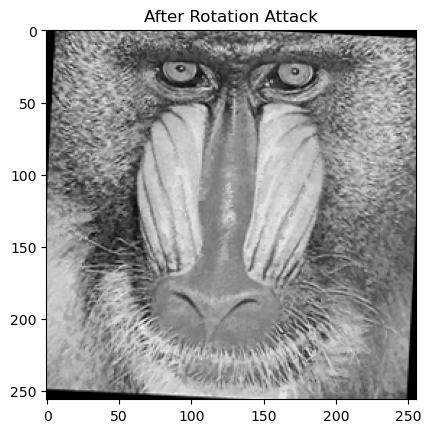

In [6]:
cv2.imwrite("Baboon Rotation Attack.png", img_rotated)
plt.figure()
plt.imshow(img_rotated,cmap='gray')
plt.title( "After Rotation Attack")

In [7]:
img=cv2.imread('Baboon 256.png')
transcol=cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
carrier=transcol[:,:,0]

Image has been attacked; 1017 of 1024 image blocks detected alteration


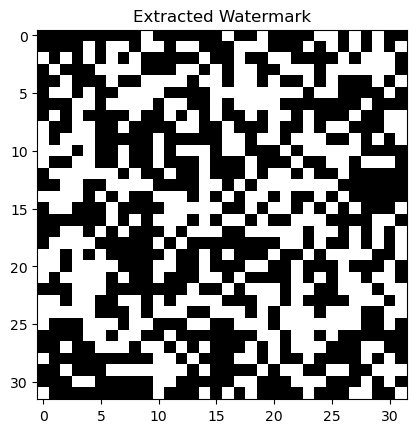

In [8]:
w_extracted=np.zeros((32, 32), dtype=int)
w_extracted, attack_count = watermark_extraction(blocks, 2, 30, carrier)
w_decoded=watermark_decoding(w_extracted, 4, 0.6, carrier)
cv2.imwrite("Watermark Rotation Attack.png", w_decoded)
if attack_count != 0:
    print("Image has been attacked;", attack_count, "of", len(blocks), "image blocks detected alteration")

In [9]:
from math import log10, sqrt

def PSNR(original, compressed):
	mse = np.mean((original - compressed) ** 2)
	if(mse == 0): # MSE is zero means no noise is present in the signal .
				# Therefore PSNR have no importance.
		return 100
	max_pixel = 255.0
	psnr = 20 * log10(max_pixel / sqrt(mse))
	return psnr

original = cv2.imread("Baboon Grayscale.png")
watermarked= cv2.imread("Baboon Rotation Attack.png", 1)
value= PSNR(original, watermarked)
print(f"PSNR value 1 is {value} dB")

PSNR value 1 is 28.523193347051155 dB


In [10]:
import math

def NC(original, extracted):
    numerator =  0
    denominator_1 = 0
    denominator_2 = 0
    for i in range(original.shape[0]):
        for j in range(original.shape[1]):
            numerator += original[i][j] * extracted[i][j]
            denominator_1 += original[i][j] ** 2
            denominator_2 += extracted[i][j] ** 2
    denominator_1 = math.sqrt(denominator_1)
    denominator_2 = math.sqrt(denominator_2)
    return numerator / (denominator_1 * denominator_2)

def mu(original, extracted):
    pixel_diff =  0
    for i in range(original.shape[0]):
        for j in range(original.shape[1]):
            if (original[i][j] != extracted[i][j]):
                pixel_diff +=  1
    return 1 - (pixel_diff / (32*32))

thresh = 128
original = cv2.imread("Watermark.png", cv2.IMREAD_GRAYSCALE)
original = cv2.threshold(original, thresh, 1, cv2.THRESH_BINARY)[1]
extracted = cv2.imread("Watermark Rotation Attack.png", cv2.IMREAD_GRAYSCALE)
extracted = cv2.threshold(extracted, thresh, 1, cv2.THRESH_BINARY)[1]
value = NC(original, extracted)
print(f"NC value of extracted watermark {value}")

NC value of extracted watermark 0.44307978563620576
